# Matrix Completion Techniques: EM with Gaussian Mixtures & Alternating Least Squares

## Problem Overview

This notebook investigates techniques for **matrix completion** within the context of **collaborative filtering**. The dataset consists of a partially observed matrix of user-movie ratings, derived from a larger Netflix-like database. Since users rate only a small subset of available movies, the matrix is inherently sparse. The goal is to **accurately predict the missing entries**, effectively reconstructing the full rating matrix.

Matrix completion plays a central role in modern recommender systems, enabling personalized content delivery by inferring user preferences from limited information.

---

## Methods Explored

Two distinct methods are explored to address this matrix completion task:

1. **Expectation-Maximization (EM) with Gaussian Mixture Models (GMMs)**:
   - A probabilistic, soft clustering approach where users are modeled as belonging to latent groups, each characterized by a multivariate Gaussian distribution.
   - The EM algorithm iteratively estimates the missing ratings and the parameters of the mixture model.

2. **Alternating Least Squares (ALS)**:
   - A matrix factorization technique commonly used in collaborative filtering applications.
   - Decomposes the user-item matrix into latent user and item factors.

---

## Evaluation Criteria

Each technique is evaluated along the following dimensions:

- **Log-likelihood**: Quantifies the fit of the probabilistic model to the observed data.
- **Bayesian Information Criterion (BIC)**: Penalizes model complexity to guard against overfitting.
- **Root Mean Squared Error (RMSE)**: Measures the accuracy of matrix reconstruction relative to a ground-truth completion.

# Overview of Matrix Completion Methods

## 1. Gaussian Mixture Model (GMM) with EM Algorithm

We model each row (user) of the matrix `X` as a sample from one of `K` Gaussian distributions. Each component of the mixture is parameterized by:
- Mean vector: $\mu_k \in \mathbb{R}^d$
- Shared variance: $\sigma^2$
- Mixing coefficient: $\pi_k$

### E-Step
We compute the **posterior probabilities** (soft assignments) that each data point belongs to each cluster:

$$
\gamma_{ik} = \frac{\pi_k \cdot \mathcal{N}(x_i | \mu_k, \sigma^2 I)}{\sum_{j=1}^K \pi_j \cdot \mathcal{N}(x_i | \mu_j, \sigma^2 I)}
$$

Here, we compute the log-likelihood and update the responsibilities using numerically stable log-sum-exp tricks.

### M-Step
We update the parameters to maximize the expected complete log-likelihood:

- Update means (only where data is observed):
  $$
  \mu_k = \frac{\sum_{i=1}^n \gamma_{ik} \cdot x_i}{\sum_{i=1}^n \gamma_{ik}}
  $$

- Update variances and mixing coefficients accordingly.

The algorithm runs until convergence of log-likelihood. The missing values in `X` are filled using the posterior-weighted means:

$$
X_{\text{pred}} = \gamma \cdot \mu
$$

---

## 2. Alternating Least Squares (ALS)

We aim to approximate the observed matrix `X` as a product of two lower-dimensional matrices:

$$
X \approx U \cdot V^T
$$

Where:
- $U \in \mathbb{R}^{n \times r}$: user latent features
- $V \in \mathbb{R}^{d \times r}$: item latent features

### Objective Function

$$
\min_{U, V} \sum_{(i, j) \in \Omega} (X_{ij} - u_i^\top v_j)^2 + \lambda \left( \|U\|^2 + \|V\|^2 \right)
$$

Here, $\Omega$ is the set of observed entries. The regularization term prevents overfitting.

### Alternating Optimization (ALS)

ALS solves this by alternating between optimizing `U` and `V` while keeping the other fixed.

#### Explicit Solution (Ridge Regression):

- Fix `V`, solve for each user vector `u_i`:

$$
u_i = \left( \sum_{j \in \Omega_i} v_j v_j^\top + \lambda I \right)^{-1} \left( \sum_{j \in \Omega_i} X_{ij} v_j \right)
$$

- Fix `U`, solve for each item vector `v_j`:

$$
v_j = \left( \sum_{i \in \Omega_j} u_i u_i^\top + \lambda I \right)^{-1} \left( \sum_{i \in \Omega_j} X_{ij} u_i \right)
$$

ALS is particularly well-suited to sparse matrices and is widely used in real-world recommender systems.

# Deriving BIC for Gaussian Mixture Models

## Bayesian Information Criterion (BIC)

The **Bayesian Information Criterion (BIC)** provides a penalty-adjusted log-likelihood that accounts for model complexity:

$$
\text{BIC} = \cdot \log \hat{L} - \frac{\log(n) \cdot p}{ 2}
$$

Where:
- $ n $: Number of observations
- $ \hat{L} $: Maximized likelihood of the model (from the E-step)
- $ p $: Number of free parameters in the model

### Parameter Count in GMM:
Each component $ k $ includes:
- $ d $ parameters for mean $ \mu_k $
- 1 for shared variance (note: sometimes variance is per cluster, but this implementation uses a shared scalar)
- $ K-1 $ parameters for mixing weights (since they sum to 1)

Total parameters:

$$
p = K \cdot d + 1 + (K - 1) = Kd + K
$$

- **Higher BIC** suggests a better model when balancing fit vs complexity.
- We compare models by computing BIC for various values of \( K \) (number of clusters) and choose the one minimizing BIC.

# Implementation and Analysis

### Library Dependencies

The following libraries are essential for our analysis:

In [1]:
import numpy as np
from scipy.special import logsumexp
from utils import *
import matplotlib.pyplot as plt
import pandas as pd

# Data Loading and Setup

This code section initializes important data structures for a matrix completion problem, particularly focused on a Netflix-like recommendation system. Let's break down each line:

1. **Setting Random Seed**
   A fixed random seed is set to ensure reproducibility of results

2. **Loading Incomplete Data**
   Loads a sparse matrix from 'netflix_incomplete.txt'. This matrix represents user-movie ratings where many entries are missing. The missing entries are what we'll try to predict.

3. **Loading Ground Truth Data**
   Loads the complete matrix with all ratings from 'netflix_complete.txt'

In [2]:
seed = 12345
X = np.loadtxt("netflix_incomplete.txt")
X_gold = np.loadtxt('netflix_complete.txt')

## Expectation-Maximization (EM) Algorithm Analysis

In [3]:
def estep(ratings_matrix: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """
    Performs the Expectation step of the EM algorithm for matrix completion.

    This step computes the posterior probabilities (responsibilities) of each user
    belonging to each Gaussian component, along with the log-likelihood of the current model.

    Args:
        ratings_matrix: np.ndarray of shape (n_users, n_items)
            Matrix containing user-item ratings where missing entries are 0
        mixture: GaussianMixture
            Current mixture model parameters containing:
            - means (mu)
            - variances (var)
            - mixing coefficients (pi)

    Returns:
        Tuple containing:
            responsibilities: np.ndarray of shape (n_users, n_components)
                Posterior probabilities of each user belonging to each component
            log_likelihood: float
                Log-likelihood of the current model
    """
    means, variances, mixing_coeffs = mixture

    # Create observation mask (1 for observed, 0 for missing)
    observation_mask = ratings_matrix.astype(bool).astype(int)

    # Compute normalized distances to cluster means
    distances = (np.sum(ratings_matrix ** 2, axis=1)[:, None] +
                (observation_mask @ means.T ** 2) -
                2 * (ratings_matrix @ means.T)) / (2 * variances)

    # Compute log-probability terms
    log_prob_terms = (-np.sum(observation_mask, axis=1).reshape(-1, 1) / 2.0) @ \
                    (np.log((2 * np.pi * variances)).reshape(-1, 1)).T
    log_probs = log_prob_terms - distances

    # Add mixing coefficients (with numerical stability term)
    log_probs = log_probs + np.log(mixing_coeffs + 1e-16)

    # Compute responsibilities using log-sum-exp trick
    log_responsibility_sums = logsumexp(log_probs, axis=1).reshape(-1, 1)
    log_responsibilities = log_probs - log_responsibility_sums

    # Compute total log-likelihood
    total_log_likelihood = np.sum(log_responsibility_sums, axis=0).item()

    return np.exp(log_responsibilities), total_log_likelihood


def mstep(ratings_matrix: np.ndarray,
                     responsibilities: np.ndarray,
                     mixture: GaussianMixture,
                     min_variance: float = .25) -> GaussianMixture:
    """
    Performs the Maximization step of the EM algorithm for matrix completion.

    Updates the mixture model parameters (means, variances, mixing coefficients)
    to maximize the expected complete log-likelihood.

    Args:
        ratings_matrix: np.ndarray of shape (n_users, n_items)
            Matrix containing user-item ratings where missing entries are 0
        responsibilities: np.ndarray of shape (n_users, n_components)
            Posterior probabilities from the E-step
        mixture: GaussianMixture
            Current mixture model parameters
        min_variance: float, default=0.25
            Minimum allowed variance to ensure numerical stability

    Returns:
        GaussianMixture
            Updated mixture model parameters
    """
    n_users, n_items = ratings_matrix.shape
    means = mixture.mu

    # Update mixing coefficients
    mixing_coeffs = np.sum(responsibilities, axis=0) / n_users

    # Create observation mask
    observation_mask = ratings_matrix.astype(bool).astype(int)

    # Update means
    mean_denominators = responsibilities.T @ observation_mask
    mean_numerators = responsibilities.T @ ratings_matrix
    valid_indices = np.where(mean_denominators >= 1)
    means[valid_indices] = mean_numerators[valid_indices] / mean_denominators[valid_indices]

    # Update variances
    variance_denominators = np.sum(responsibilities *
                                 np.sum(observation_mask, axis=1).reshape(-1, 1), axis=0)
    squared_distances = np.sum(ratings_matrix ** 2, axis=1)[:, None] + \
                       (observation_mask @ means.T ** 2) - \
                       2 * (ratings_matrix @ means.T)

    new_variances = np.maximum(
        np.sum(responsibilities * squared_distances, axis=0) / variance_denominators,
        min_variance
    )

    return GaussianMixture(means, new_variances, mixing_coeffs)

def run(ratings_matrix: np.ndarray,
                       initial_mixture: GaussianMixture,
                       convergence_threshold: float = 1e-6) -> Tuple[GaussianMixture, np.ndarray, float]:
    """
    Trains a Gaussian Mixture Model using the EM algorithm for matrix completion.

    Iteratively performs E-step and M-step until convergence, as determined by
    the relative change in log-likelihood.

    Args:
        ratings_matrix: np.ndarray of shape (n_users, n_items)
            Matrix containing user-item ratings where missing entries are 0
        initial_mixture: GaussianMixture
            Initial mixture model parameters
        convergence_threshold: float, default=1e-6
            Convergence criterion for relative change in log-likelihood

    Returns:
        Tuple containing:
            final_mixture: GaussianMixture
                Trained mixture model parameters
            final_responsibilities: np.ndarray
                Final responsibility assignments
            final_log_likelihood: float
                Final log-likelihood value
    """
    responsibilities = None
    previous_log_likelihood = None
    current_log_likelihood = None
    current_mixture = initial_mixture

    while (previous_log_likelihood is None or
           (np.abs(previous_log_likelihood - current_log_likelihood) >
            convergence_threshold * np.abs(current_log_likelihood))):

        previous_log_likelihood = current_log_likelihood
        responsibilities, current_log_likelihood = estep(ratings_matrix, current_mixture)
        current_mixture = mstep(ratings_matrix, responsibilities, current_mixture)

    return current_mixture, responsibilities, current_log_likelihood

def fill_matrix(ratings_matrix: np.ndarray, mixture: GaussianMixture) -> np.ndarray:
    """
    Completes a partially observed matrix using a trained Gaussian mixture model.

    For each user, computes the expected ratings for missing entries based on
    their posterior probabilities of belonging to each component.

    Args:
        ratings_matrix: np.ndarray of shape (n_users, n_items)
            Incomplete matrix where missing entries are 0
        mixture: GaussianMixture
            Trained mixture model parameters

    Returns:
        np.ndarray of shape (n_users, n_items)
            Completed matrix with predictions for missing entries
    """
    completed_matrix = ratings_matrix.copy()
    means = mixture.mu

    # Compute responsibilities for all users
    responsibilities, _ = estep(ratings_matrix, mixture)

    # Find indices of missing entries
    missing_indices = np.where(ratings_matrix == 0)

    # Fill missing entries with weighted means
    completed_matrix[missing_indices] = (responsibilities @ means)[missing_indices]

    return completed_matrix

### Model Exploration
We systematically evaluate the EM algorithm across multiple components (K = 1 to 50) to identify the optimal model configuration. The analysis includes:

- Log-likelihood evaluation for model fit
- Bayesian Information Criterion (BIC) for model selection
- Root Mean Square Error (RMSE) for prediction accuracy

The results are visualized through comprehensive plots that demonstrate the performance metrics across different model complexities.

In [4]:
K = list(range(1, 50))
results_log_liklihood = []
results_bic = []
results_rmse = []
for k in K:
    mixture_post_init = init(X, k, seed)
    mixture, post, log_lik = run(X,
                                 mixture_post_init[0])
    X_pred = fill_matrix(X, mixture)

    results_log_liklihood.append(log_lik)
    results_bic.append(bic(X, mixture, log_lik))
    results_rmse.append(rmse(X_gold, X_pred))

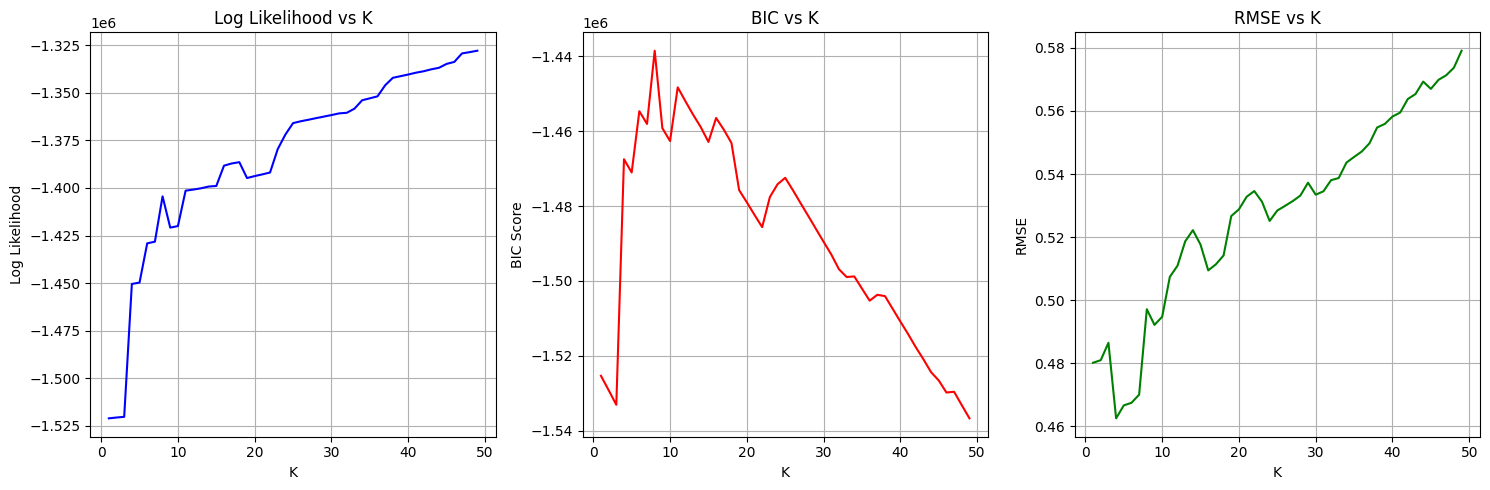

In [5]:
# Create figure with subplots
plt.figure(figsize=(15, 5))

# Plot 1: Log Likelihood
plt.subplot(131)
plt.plot(K, results_log_liklihood, 'b-', label='Log Likelihood')
plt.xlabel('K')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood vs K')
plt.grid(True)

# Plot 2: BIC
plt.subplot(132)
plt.plot(K, results_bic, 'r-', label='BIC')
plt.xlabel('K')
plt.ylabel('BIC Score')
plt.title('BIC vs K')
plt.grid(True)

# Plot 3: RMSE
plt.subplot(133)
plt.plot(K, results_rmse, 'g-', label='RMSE')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('RMSE vs K')
plt.grid(True)

plt.tight_layout()
plt.show()


### Model Selection via BIC
We evaluate different model configurations using the Bayesian Information Criterion (BIC) to determine the optimal number of components. BIC helps balance model complexity with goodness of fit.

In [6]:
results_df = pd.DataFrame({
    'K': K,
    'Log Likelihood': results_log_liklihood,
    'BIC': results_bic,
    'RMSE': results_rmse
})

results_df.iloc[np.argmax(results_bic)].to_dict()

{'K': 8.0,
 'Log Likelihood': -1404425.7999294822,
 'BIC': -1438511.3443174758,
 'RMSE': 0.49712452753008496}

### Performance Evaluation via RMSE
The Root Mean Square Error (RMSE) metric is used to assess prediction accuracy. Lower RMSE values indicate better performance of the matrix completion task.

In [7]:
results_df.iloc[np.argmin(results_rmse)].to_dict()

{'K': 4.0,
 'Log Likelihood': -1450444.0697928537,
 'BIC': -1467485.0694676414,
 'RMSE': 0.4625235992999419}

## Alternating Least Squares (ALS) Algorithm Implementation

In [8]:
def als(Y: np.ndarray, rank: int = 10, lambda_reg: float = 0.1, iterations: int = 10) -> tuple:
    """
    Implements the Alternating Least Squares (ALS) algorithm for matrix factorization.

    This function decomposes a rating matrix Y into two lower-rank matrices U and V
    such that Y ≈ U @ V.T. The algorithm alternates between fixing U and solving for V,
    then fixing V and solving for U, using ridge regression with L2 regularization.

    Args:
        Y (np.ndarray): Rating matrix of shape (n_users, n_items) where:
                        - Positive values indicate observed ratings
                        - Zero values are treated as unobserved
                        - Each row represents a user
                        - Each column represents an movie

        rank (int, optional): The latent feature dimension for the decomposition.
                             Smaller values give simpler models but may underfit.
                             Larger values allow more complex patterns but may overfit.
                             Defaults to 10.

        lambda_reg (float, optional): L2 regularization parameter.
                                    Controls the strength of regularization.
                                    Defaults to 0.1.

        iterations (int, optional): Number of iterations to alternate between updating U and V.
                                  More iterations allow better convergence but take longer.
                                  Defaults to 10.

    Returns:
        tuple: Contains:
            - U (np.ndarray): User latent factor matrix of shape (n_users, rank)
            - V (np.ndarray): Item latent factor matrix of shape (n_items, rank)
    """

    # Create mask for observed ratings (positive values)
    observed_ratings = Y > 0

    # Get dimensions of the rating matrix
    n_users, n_items = Y.shape

    # Initialize user and item matrices with random values
    U = np.random.rand(n_users, rank) * 0.1
    V = np.random.rand(n_items, rank) * 0.1

    # Identity matrix for regularization
    reg_matrix = lambda_reg * np.eye(rank)

    # Alternate between updating U and V
    for _ in range(iterations):
        # Update U while keeping V fixed
        for a in range(n_users):
            # Get indices of items rated by user a
            idx = observed_ratings[a]

            # Skip users with no ratings
            if not idx.any():
                continue

            # Get relevant item factors and ratings
            V_a = V[idx]  # Items rated by user a
            Y_a = Y[a, idx]  # Ratings given by user a

            # Solve ridge regression problem
            # U_a = (V_a^T V_a + λI)^-1 V_a^T Y_a
            A = V_a.T @ V_a + reg_matrix
            b = V_a.T @ Y_a
            U[a] = np.linalg.solve(A, b)

        # Update V while keeping U fixed
        for i in range(n_items):
            # Get indices of users who rated item i
            idx = observed_ratings[:, i]

            # Skip items with no ratings
            if not idx.any():
                continue

            # Get relevant user factors and ratings
            U_i = U[idx]  # Users who rated item i
            Y_i = Y[idx, i]  # Ratings given to item i

            # Solve ridge regression problem
            # V_i = (U_i^T U_i + λI)^-1 U_i^T Y_i
            A = U_i.T @ U_i + reg_matrix
            b = U_i.T @ Y_i
            V[i] = np.linalg.solve(A, b)

    return U, V

### Rank Analysis
We explore the algorithm's performance across multiple latent ranks:

In [9]:
ranks = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
rmse_als = []
for dm in ranks:
    U_l, V_l = als(X, dm, 0.1, 50)
    rmse_als.append(rmse(X_gold, U_l @ V_l.T))

### Performance Visualization

The visualization helps identify the optimal dimensionality for the given dataset and provides insights into the algorithm's behavior at different complexity levels.

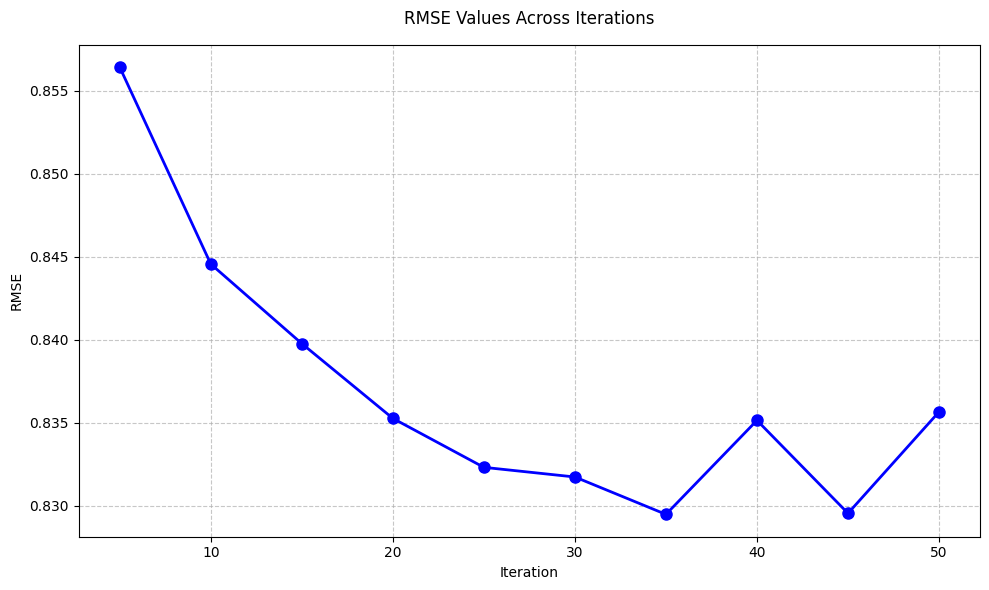

In [10]:
# Create x-axis values (dimensions)
x = ranks

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, rmse_als, 'b-o', linewidth=2, markersize=8)

# Customize the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('RMSE Values Across Iterations', fontsize=12, pad=15)
plt.xlabel('Iteration', fontsize=10)
plt.ylabel('RMSE', fontsize=10)

# Format y-axis to show values with 3 decimal places
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))

# Add minor grid lines
plt.grid(True, which='minor', linestyle=':', alpha=0.4)

# Adjust the plot margins
plt.margins(x=0.05)

# Show the plot
plt.tight_layout()
plt.show()

# Conclusion and Analysis

## EM Algorithm with Gaussian Mixture Models
Based on the Bayesian Information Criterion (BIC) analysis, the optimal number of components is K=8. This suggests that user rating patterns can be effectively modeled using 8 distinct clusters.

## Alternating Least Squares (ALS)
The optimal dimensionality for the latent factor space is 35. This indicates that 35 latent features are sufficient to capture the underlying patterns in the rating matrix.

## Comparative Analysis
* The EM algorithm demonstrates superior performance compared to ALS in terms of prediction accuracy
* Key advantages of EM:
  - More robust handling of missing data
  - Better capture of underlying user rating distributions

* However, ALS offers:
  - Faster computation for large-scale problems
  - Direct optimization of the prediction objective

This analysis suggests that for this particular dataset, the EM algorithm with Gaussian mixtures provides a more effective approach to matrix completion.